# Assessment 01

In this assessment we wish to train some a model on some data, in order to allow us to analyse and predict normal vs non-normal (potentially malicious) traffic. We will be testing our model on the [KD99 (10%)](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html) data set.

We first need to import the following list of python packages:

In [155]:
import pandas as pd
import requests
import zipfile
from io import StringIO
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from scipy.spatial import distance

pd.set_option('display.max_rows', 500)

## Fetching the data

Previous to this report, we have already partitioned the data in a 90/10 split for training and testing purposes. The data is found in the [GitHub Repository](https://github.com/Galeforse/DST-Assessment-01) under [Data](https://github.com/Galeforse/DST-Assessment-01/tree/main/Data), but to read the data in you don't need to download it yourself, as the code below reads the data from the csv directly from the repository.

We allocate our training data as `df_tr` (dataframe training) and our testing data as `df_test` (dataframe testing). Throughout this document as we manipulate the data for various reasons, we will keep to this naming convention, but will often reassign the transformed data to another variable so that if we need to fetch the original data for any reason, we don't have to repeat this importing step each time.

In [156]:
start = dt.datetime.now()
df_tr = pd.read_csv("https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_train.csv.zip")
df_test = pd.read_csv("https://github.com/Galeforse/DST-Assessment-01/raw/main/Data/kd_test.csv.zip")
print("Data fetched in:" ,dt.datetime.now()-start)
df_tr.head()

Data fetched in: 0:00:06.051604


,Unnamed: 0,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,folds
0,44625,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
1,339463,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
2,321570,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1
3,355860,0,tcp,private,S0,0,0,0,0,0,...,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.,1
4,9708,0,icmp,ecr_i,SF,1032,0,0,0,0,...,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.,1


## About the Data

First we will create a data quality report on both the test and training data to get an overview of what kind of values the data contains, as well as to check for any missing data. We define the data quality report function, and then apply the function to each set of data.

In [157]:
def data_qual(df):
    global data_quality_report
    #DataFrame with columns
    columns = pd.DataFrame(list(df.columns.values[1:]))

    #DataFrame with data types
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])

    #DataFrame with Count
    data_count = pd.DataFrame(df.count(), columns=['Count'])

    #DataFrame with unique values
    unique_value_counts = pd.DataFrame(columns=['Unique Values'])
    for v in list(df.columns.values):
        unique_value_counts.loc[v] = [df[v].nunique()]

    missing_data_counts = pd.DataFrame(df.isnull().sum(), columns=['Missing Values'])
    data_quality_report = data_types.join(data_count).join(unique_value_counts).join(missing_data_counts)
    print('Data Quality Report')

In [158]:
data_qual(df_tr)
print("Training Data")
data_quality_report

Data Quality Report
Training Data


,Data Type,Count,Unique Values,Missing Values
Unnamed: 0,int64,444619,444619,0
duration,int64,444619,2286,0
protocol_type,object,444619,3,0
service,object,444619,65,0
flag,object,444619,11,0
src_bytes,int64,444619,3182,0
dst_bytes,int64,444619,10278,0
land,int64,444619,2,0
wrong_fragment,int64,444619,3,0
urgent,int64,444619,3,0


In [159]:
data_qual(df_test)
print("Testing Data")
data_quality_report

Data Quality Report
Testing Data


,Data Type,Count,Unique Values,Missing Values
Unnamed: 0,int64,49402,49402,0
duration,int64,49402,433,0
protocol_type,object,49402,3,0
service,object,49402,62,0
flag,object,49402,10,0
src_bytes,int64,49402,1243,0
dst_bytes,int64,49402,3177,0
land,int64,49402,1,0
wrong_fragment,int64,49402,3,0
urgent,int64,49402,2,0


We'll go into what these reports tell us further on in the report but for now the most important information that immediately jumps out to us is the non-numerical data (those labelled "object") and the fact that neither of our data sets are missing values.

## Overview of the attacks

As we are interested in predicting normal vs non-normal traffic, we are going to count how many of each type of traffic occurs in our data, this includes all attacks seperated by type as well as normal traffic. We use the following code to show a table representing the attacks through values, from which we will then form a visual representation of the types of attack in relation to each other.

In [160]:
attack = df_tr.groupby("label").size().sort_values(ascending=False)
attack = pd.DataFrame(attack)
attack.reset_index(level=0, inplace=True)
attack.columns = ['Attack','Count']
attack

,Attack,Count
0,smurf.,252590
1,neptune.,96598
2,normal.,87549
3,back.,1989
4,satan.,1436
5,ipsweep.,1100
6,portsweep.,937
7,warezclient.,917
8,teardrop.,887
9,pod.,236


Text(0.5, 1.0, 'Number of times each type of traffic is observed in the training data.')

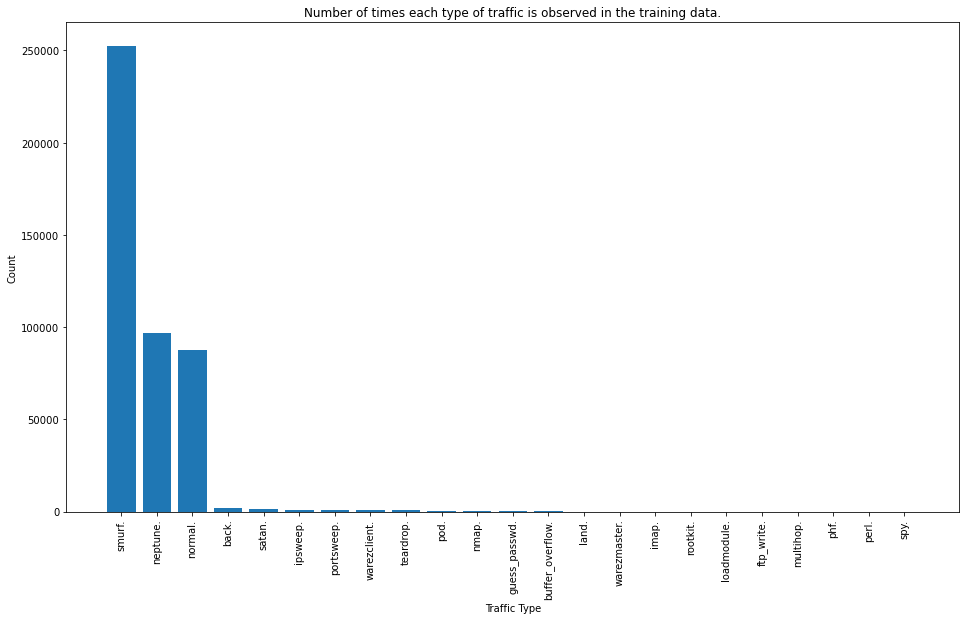

In [161]:
plt.figure(figsize=(16,9))
plt.bar(attack["Attack"],attack["Count"])
plt.xlabel("Traffic Type")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Number of times each type of traffic is observed in the training data.")

We see that most types of attack are insignifcant compared to the three most common entries. Even if we were to stack them all together they would not be close to having as many entries as normal traffic. Normal itself is the dwarfed in comparison to the amount of smurf attacks on the data, with more than double the occurences.

## Data Cleansing

We can see from our data quality report above that there are no missing values in any of the columns, this is good to know as we do not want missing values when we are conducting analysis. We'll also just use the following code (supplied as part of pandas) to remove any duplicate values in our data.

In [162]:
df_tr.drop_duplicates(keep='first', inplace = True)
df_test.drop_duplicates(keep='first', inplace = True)

In generating our training data we have created a folds column that is not found in the original data set and so we remove it to keep it in line with the rest of the data, and also remove the first `"Unnamed"` column that we has been generated in the data as this was also not present in the original data.

In [163]:
df_tr2 = df_tr.drop(["folds"],axis=1)
df_tr2 = df_tr2.drop(df_tr2.columns[0],axis=1)
df_tr2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
1,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
3,0,tcp,private,S0,0,0,0,0,0,0,...,15,0.06,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
4,0,icmp,ecr_i,SF,1032,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.


In [164]:
df_test2 = df_test
df_test2 = df_test2.drop(df_test2.columns[0],axis=1)
df_test2.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,private,S0,0,0,0,0,0,0,...,1,0.00,0.05,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
1,0,icmp,ecr_i,SF,520,0,0,0,0,0,...,255,1.00,0.00,1.0,0.0,0.0,0.0,0.0,0.0,smurf.
2,0,tcp,http,SF,186,21709,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,private,S0,0,0,0,0,0,0,...,18,0.07,0.07,0.0,0.0,1.0,1.0,0.0,0.0,neptune.
4,0,tcp,http,SF,341,6843,0,0,0,0,...,255,1.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,normal.


## Further cleansing specific for use in the model

When applying machine learning techniques, models can be extrememly specific about the type of data that they take. Therefore we are going to conduct some slightly more specific data cleansing than just removal of certain values in order to make our model work without problems.

### Categorical Data

As mentioned earlier, our data has 4 categorical data values. For now we are going to ignore the `"label"` column that tells us the attack type, as we will deal with this later, so we are left with the `"protocol_type"`, `"service"` and `"flag"` columns. We are going to use a technique called one-hot encoding. This technique allocates seperate columns that allows the model to work with "on" and "off" (represented in binary) values rather than categorical data that it may not know how to work with. Some models can take categorical data but I thought it was safe and useful for future reference to practice using one-hot encoding.

This technique can also be used with the `get_dummies` function included with pandas, however when I first tried doing this with my data I ran into problems and so used this alternative technique; later on in this report I will try an alternative version of the train/test using dummies and a slightly modified technique. We have to repeat this process 3 times for each of our categorical data columns.

In [165]:
#Protocol--------------------------------------------------------------
proto = list(df_tr2["protocol_type"].values)
proto = list(set(proto))

one_hot = CountVectorizer(vocabulary=proto, binary=True)
tr_proto = one_hot.fit_transform(df_tr2["protocol_type"].values)
test_proto = one_hot.transform(df_test2["protocol_type"].values)

#Service--------------------------------------------------------------
service = list(df_tr2["service"].values)
service = list(set(service))

one_hot = CountVectorizer(vocabulary=service, binary=True)
tr_service = one_hot.fit_transform(df_tr2["service"].values)
test_service = one_hot.transform(df_test2["service"].values)

#flag--------------------------------------------------------------
flag = list(df_tr2["flag"].values)
flag = list(set(flag))

one_hot = CountVectorizer(vocabulary=flag, binary=True)
tr_flag = one_hot.fit_transform(df_tr2["flag"].values)
test_flag = one_hot.transform(df_test2["flag"].values)

This generates six matrices, one for training and test data of each categorical data value. We will come back to these in just a few steps in order to include them in cleansed testing data.

### Attack type

Now we are going to address the attack type, or `label` column in the data. First of all we would like to seperate our data into normal and non-normal traffic as per the brief. To do this we will first of all refer back to our `attack` data generated near the top of this report and remove the data labelled `normal.` from it.

In [166]:
global x
x = []
for i in attack["Attack"]:
    x.append(i)
x.remove("normal.")

The reason we have done this is because we are now going to access the above variable `x` to replace all values in the `label` column of our data that are not normal with the label "non-normal" as we are not interested in the specific type of attack, just whether it is normal or not.

We then proceed to seperate our data for use with the model. We parse our training and test data into 2 new data sets each: `x` data which includes all data other than the label column, and `y` data which only includes the column of data indicating whether or not the data is normal or non-normal. We will train by comparing `x` with `y` in the training set, and then test it by seeing how accurately our model can predict `y` given `x` in the testing set.

In [167]:
df_tr2["label"] = df_tr2["label"].replace([x],'non-normal')
df_test2["label"] = df_test2["label"].replace([x],'non-normal')
df_tr_x = df_tr2.drop(["label"],axis=1)
df_tr_y = df_tr2["label"]
df_test_x = df_test2.drop(["label"],axis=1)
df_test_y = df_test2["label"]

### Data scaling for numerical data

As a general rule for data science it is good to scale data so that numerical variables have the same scale, generally so that they have a mean value of 0, and a standard deviation of 1. Again this is not require for all models but is still good practice to learn and will not negatively impact results.

We define a function for scaling as we are going to have to run this process many times: for each of the columns containing numerical values in the data. I would have like to have iterated this so I didn't have to type out so many uses of the function, however I found it overly complicated with defining the correct `global` variables that I decided to just do it "manually".

In [168]:
def scaling(train, test, feature_name):
    scaler = StandardScaler()
    scaler1 = scaler.fit_transform(train[feature_name].values.reshape(-1,1))
    scaler2 = scaler.transform(test[feature_name].values.reshape(-1,1))
 
    return scaler1, scaler2

In [169]:
duration1, duration2 = scaling(df_tr_x,df_test_x,"duration")
src_bytes1, src_bytes2 = scaling(df_tr_x,df_test_x,"src_bytes")
dst_bytes1, dst_bytes2 = scaling(df_tr_x,df_test_x,"dst_bytes")
land1, land2 = scaling(df_tr_x,df_test_x,"land")
wrong_fragment1, wrong_fragment2 = scaling(df_tr_x,df_test_x,"wrong_fragment")
urgent1, urgent2 = scaling(df_tr_x,df_test_x,"urgent")
hot1, hot2 = scaling(df_tr_x,df_test_x,"hot")
num_failed_logins1, num_failed_logins2 = scaling(df_tr_x,df_test_x,"num_failed_logins")
logged_in1, logged_in2 = scaling(df_tr_x,df_test_x,"logged_in")
lnum_compromised1, lnum_compromised2 = scaling(df_tr_x,df_test_x,"lnum_compromised")
lroot_shell1, lroot_shell2 = scaling(df_tr_x,df_test_x,"lroot_shell")
lsu_attempted1, lsu_attempted2 = scaling(df_tr_x,df_test_x,"lsu_attempted")
lnum_root1, lnum_root2 = scaling(df_tr_x,df_test_x,"lnum_root")
lnum_file_creations1, lnum_file_creations2 = scaling(df_tr_x,df_test_x,"lnum_file_creations")
lnum_shells1, lnum_shells2 = scaling(df_tr_x,df_test_x,"lnum_shells")
lnum_access_files1, lnum_access_files2 = scaling(df_tr_x,df_test_x,"lnum_access_files")
lnum_outbound_cmds1, lnum_outbound_cmds2 = scaling(df_tr_x,df_test_x,"lnum_outbound_cmds")
is_host_login1, is_host_login2 = scaling(df_tr_x,df_test_x,"is_host_login")
is_guest_login1, is_guest_login2 = scaling(df_tr_x,df_test_x,"is_guest_login")
count1, count2 = scaling(df_tr_x,df_test_x,"count")
srv_count1, srv_count2 = scaling(df_tr_x,df_test_x,"srv_count")
serror_rate1, serror_rate2 = scaling(df_tr_x,df_test_x,"serror_rate")
srv_serror_rate1, srv_serror_rate2 = scaling(df_tr_x,df_test_x,"srv_serror_rate")
rerror_rate1, rerror_rate2 = scaling(df_tr_x,df_test_x,"rerror_rate")
srv_rerror_rate1, srv_rerror_rate2 = scaling(df_tr_x,df_test_x,"srv_rerror_rate")
same_srv_rate1, same_srv_rate2 = scaling(df_tr_x,df_test_x,"same_srv_rate")
diff_srv_rate1, diff_srv_rate2 = scaling(df_tr_x,df_test_x,"diff_srv_rate")
srv_diff_host_rate1, srv_diff_host_rate2 = scaling(df_tr_x,df_test_x,"srv_diff_host_rate")
dst_host_count1, dst_host_count2 = scaling(df_tr_x,df_test_x,"dst_host_count")
dst_host_srv_count1, dst_host_srv_count2 = scaling(df_tr_x,df_test_x,"dst_host_srv_count")
dst_host_same_srv_rate1, dst_host_same_srv_rate2 = scaling(df_tr_x,df_test_x,"dst_host_same_srv_rate")
dst_host_diff_srv_rate1, dst_host_diff_srv_rate2 = scaling(df_tr_x,df_test_x,"dst_host_diff_srv_rate")
dst_host_same_src_port_rate1, dst_host_same_src_port_rate2 = scaling(df_tr_x,df_test_x,"dst_host_same_src_port_rate")
dst_host_srv_diff_host_rate1, dst_host_srv_diff_host_rate2 = scaling(df_tr_x,df_test_x,"dst_host_srv_diff_host_rate")
dst_host_serror_rate1, dst_host_serror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_serror_rate")
dst_host_srv_serror_rate1, dst_host_srv_serror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_srv_serror_rate")
dst_host_rerror_rate1, dst_host_rerror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_rerror_rate")
dst_host_srv_rerror_rate1, dst_host_srv_rerror_rate2 = scaling(df_tr_x,df_test_x,"dst_host_srv_rerror_rate")

After the scaling is complete we combine all of our matrices and arrays together in the order they were in before transform for both testing and training data. We denote this newly scaled testing and training data with an s after to represent "scaled". When recombining we also include the one-hot encoded data that we created above.

In [170]:
df_tr_xs = hstack((duration1, tr_proto, tr_service, tr_flag, src_bytes1, dst_bytes1, land1, wrong_fragment1
                    , urgent1, hot1, num_failed_logins1, logged_in1, lnum_compromised1, lroot_shell1, lsu_attempted1
                    , lnum_root1, lnum_file_creations1, lnum_shells1, lnum_access_files1, is_host_login1, is_guest_login1
                    , count1, srv_count1, serror_rate1, srv_serror_rate1, rerror_rate1, srv_rerror_rate1, same_srv_rate1
                    , diff_srv_rate1, srv_diff_host_rate1, dst_host_count1, dst_host_srv_count1, dst_host_same_srv_rate1
                    , dst_host_diff_srv_rate1, dst_host_same_src_port_rate1, dst_host_srv_diff_host_rate1
                    , dst_host_serror_rate1, dst_host_srv_serror_rate1, dst_host_rerror_rate1, dst_host_srv_rerror_rate1))
df_test_xs = hstack((duration2, test_proto, test_service, test_flag, src_bytes2, dst_bytes2, land2, wrong_fragment2
                   , urgent2, hot2, num_failed_logins2, logged_in2, lnum_compromised2, lroot_shell2, lsu_attempted2
                   , lnum_root2, lnum_file_creations2, lnum_shells2, lnum_access_files2, is_host_login2, is_guest_login2
                   , count2, srv_count2, serror_rate2, srv_serror_rate2, rerror_rate2, srv_rerror_rate2, same_srv_rate2
                   , diff_srv_rate2, srv_diff_host_rate2, dst_host_count2, dst_host_srv_count2, dst_host_same_srv_rate2
                   , dst_host_diff_srv_rate2, dst_host_same_src_port_rate2, dst_host_srv_diff_host_rate2
                   , dst_host_serror_rate2, dst_host_srv_serror_rate2, dst_host_rerror_rate2, dst_host_srv_rerror_rate2))

print(df_tr_xs.shape)
print(df_test_xs.shape)

(444619, 116)
(49402, 116)


By printing the shape we can see our data has the same amount of values as we saw right at the beginning of our analysis for their respective data (training or testing) and so it is good to know that we have not lost any values. However, we have gained columns as a side effect of the one-hot encoding creating additional columns.

Now we have cleansed our data we are ready to move onto actually training and testing our model.

## Training the model

### Logistic Regression

I have decided to test logistic regression and have already imported the appropriate packages at the beginning of the report. The first thing we do is define the `LogisticRegression()` function to a new variable LogReg, which takes the default values for the function other than our specified `max_iter`. I changed this to 5000 as by default it is equal to 100, and on first attempt of training my model, I encountered an error where the max number of iterations had been reached.

We also define a grid space for use with the `GridSearchCV` function. This function performs tuning on hyperparameters (specified in `grid`), to determine optimal values for a model. It also performs cross validation to determine which hyperparameters give the most accurate results. We then define a new function `logr_grid` that uses `GridSearchCV` on our function `LogReg`, with 5-fold cross validation.

In [171]:
LogReg = LogisticRegression(max_iter=5000)

grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logr_grid = GridSearchCV(LogReg, grid, cv=5)

### Observing results

We define the following function to provide a classifier of a our results which uses several function from the `sklearn.metrics` package. The most important of these is the confusion matrix which shows us the true/false positives/negatives in the form:

```
[[TP , FP]
[FN , TN]]
```

True Positive: Predicted true, is true; In our model this is predicted non-normal, is non-normal.

False Postive: Predicted true, is false; In our model this is predicted non-normal, is normal.

False Negative: Predicted false, is true; In our model this is predicted normal, is non-normal.

True Negative: Predicted false, is false; In our model this is predicted normal, is normal.


In [172]:
def classification_eval(estimator,df_test,df_test_resp):
    y_pred =estimator.predict(df_test)
    dec = np.int64(np.ceil(np.log10(len(df_test_resp))))
    
    print("Confusion Matrix")
    print(metrics.confusion_matrix(df_test_resp,y_pred),'\n')
    
    print('Classification report')
    print(metrics.classification_report(df_test_resp, y_pred, digits=dec))
    
    print("Scalar Metrics")
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', metrics.matthews_corrcoef(df_test_resp, y_pred)))
    print(format_str % ("Cohen's kappa", metrics.cohen_kappa_score(df_test_resp, y_pred)))
    print(format_str % ('Accuracy', metrics.accuracy_score(df_test_resp, y_pred)))

We finally come to fitting our model. We also use `datetime` to calculate how long it takes to fit the model. First of all we fit our data using the standard Logistic Regression model, and then using our `logr_grid` function with cross-validation.

In [173]:
print('Fitting the basic model')
start = dt.datetime.now()
LogReg.fit(df_tr_xs,df_tr_y)
print('Completed in:',dt.datetime.now()-start)

Fitting the basic model
Completed in: 0:00:53.660644


In [174]:
print('Fitting the model using GridSearchCV with cross-validation')
start = dt.datetime.now()
logr_grid.fit(df_tr_xs,df_tr_y)
print('Completed in:',dt.datetime.now()-start)

Fitting the model using GridSearchCV with cross-validation
Completed in: 0:39:10.651452


We will first use our `classification_eval` function to predict the result on the data it was trained on, which hopefully should have quite high accuracy as it is quite familiar with the data itself. We'll start by checking this on our basic model.

In [175]:
classification_eval(LogReg,df_tr_xs,df_tr_y)

Confusion Matrix
[[356672    398]
 [   299  87250]] 

Classification report
              precision    recall  f1-score   support

  non-normal   0.999162  0.998885  0.999024    357070
     normal.   0.995459  0.996585  0.996022     87549

    accuracy                       0.998432    444619
   macro avg   0.997311  0.997735  0.997523    444619
weighted avg   0.998433  0.998432  0.998433    444619

Scalar Metrics
          MCC = 0.995046
Cohen's kappa = 0.995045
     Accuracy = 0.998432


We now apply the same function to our `x` testing data to see if it can successfully predict the `y` testing data and compare the two.

In [176]:
classification_eval(LogReg,df_test_xs,df_test_y)

Confusion Matrix
[[39632    41]
 [   35  9694]] 

Classification report
              precision    recall  f1-score   support

  non-normal    0.99912   0.99897   0.99904     39673
     normal.    0.99579   0.99640   0.99610      9729

    accuracy                        0.99846     49402
   macro avg    0.99745   0.99768   0.99757     49402
weighted avg    0.99846   0.99846   0.99846     49402

Scalar Metrics
          MCC = 0.99514
Cohen's kappa = 0.99514
     Accuracy = 0.99846


We'll now repeat the above steps on our cross-validated model.

In [177]:
classification_eval(logr_grid,df_tr_xs,df_tr_y)

Confusion Matrix
[[356685    385]
 [   292  87257]] 

Classification report
              precision    recall  f1-score   support

  non-normal   0.999182  0.998922  0.999052    357070
     normal.   0.995607  0.996665  0.996136     87549

    accuracy                       0.998477    444619
   macro avg   0.997395  0.997793  0.997594    444619
weighted avg   0.998478  0.998477  0.998478    444619

Scalar Metrics
          MCC = 0.995188
Cohen's kappa = 0.995188
     Accuracy = 0.998477


In [178]:
classification_eval(logr_grid,df_test_xs,df_test_y)

Confusion Matrix
[[39633    40]
 [   33  9696]] 

Classification report
              precision    recall  f1-score   support

  non-normal    0.99917   0.99899   0.99908     39673
     normal.    0.99589   0.99661   0.99625      9729

    accuracy                        0.99852     49402
   macro avg    0.99753   0.99780   0.99766     49402
weighted avg    0.99852   0.99852   0.99852     49402

Scalar Metrics
          MCC = 0.99533
Cohen's kappa = 0.99533
     Accuracy = 0.99852


## Hamming Distance



In [179]:
tr_y_pred = LogReg.predict(df_tr_xs)
test_y_pred = LogReg.predict(df_test_xs)
tr_y_pred2 = logr_grid.predict(df_tr_xs)
test_y_pred2 = logr_grid.predict(df_test_xs)

In [181]:
global df_tr_yh
df_tr_yh = []
for i in df_tr_y:
    if i == "non-normal":
        df_tr_yh.append(1)
    else:
        df_tr_yh.append(0)
        
global df_tr_y_pred
df_tr_y_pred = []
for i in tr_y_pred:
    if i == "non-normal":
        df_tr_y_pred.append(1)
    else:
        df_tr_y_pred.append(0)
        
global df_tr_y_pred2
df_tr_y_pred2 = []
for i in tr_y_pred2:
    if i == "non-normal":
        df_tr_y_pred2.append(1)
    else:
        df_tr_y_pred2.append(0)
        
global df_test_yh
df_test_yh = []
for i in df_test_y:
    if i == "non-normal":
        df_test_yh.append(1)
    else:
        df_test_yh.append(0)

global df_test_y_pred
df_test_y_pred = []
for i in test_y_pred:
    if i == "non-normal":
        df_test_y_pred.append(1)
    else:
        df_test_y_pred.append(0)
        
global df_test_y_pred2
df_test_y_pred2 = []
for i in test_y_pred2:
    if i == "non-normal":
        df_test_y_pred2.append(1)
    else:
        df_test_y_pred2.append(0)

In [182]:
print("Hamming distance on training data with standard LogReg")
print(distance.hamming(df_tr_y_pred,df_tr_yh))
print("")
print("Hamming distance on testing data with standard LogReg")
print(distance.hamming(df_test_y_pred,df_test_yh))
print("")
print("Hamming distance on training data with GridSearchCV")
print(distance.hamming(df_tr_y_pred2,df_tr_yh))
print("")
print("Hamming distance on testing data with GridSearchCV")
print(distance.hamming(df_test_y_pred2,df_test_yh))

Hamming distance on training data with standard LogReg
0.0015676343116241096

Hamming distance on testing data with standard LogReg
0.001538399255090887

Hamming distance on training data with GridSearchCV
0.0015226519784354694

Hamming distance on testing data with GridSearchCV
0.0014776729687057204


## Alternative training and testing

As mentioned earlier I am curious how the model predicts the data without the scaling steps I conducted earlier. I will do less explaining here as most of the process is pretty much the same as in the above section. However I am going to use `pd.get_dummies` over using the one-hot encoding method from above, and I am going to supply my data to the model un-scaled, other than changing the `label` column to be made up of just normal and non-normal values.

In [183]:
df_tr_xd = pd.get_dummies(df_tr_x)
df_test_xd = pd.get_dummies(df_test_x)

df_test_xd["service_X11"] = 0
df_test_xd["service_pm_dump"] = 0
df_test_xd["service_red_i"] = 0
df_test_xd["service_tim_i"] = 0
df_test_xd["flag_RSTOS0"] = 0
df_tr_xd["service_tftp_u"] = 0

In [184]:
LogReg2 = LogisticRegression(max_iter=5000)

grid={"C":np.logspace(-3,3,7), "penalty":["l2"]}
logr_grid2 = GridSearchCV(LogReg2, grid, cv=5)

print('Fitting the basic model')
start = dt.datetime.now()
LogReg2.fit(df_tr_xd,df_tr_y)
print('Completed in:',dt.datetime.now()-start)

Fitting the basic model
Completed in: 0:00:38.688482


In [185]:
print('Fitting the model using GridSearchCV with cross-validation')
start = dt.datetime.now()
logr_grid2.fit(df_tr_xd,df_tr_y)
print('Completed in:',dt.datetime.now()-start)

Fitting the model using GridSearchCV with cross-validation
Completed in: 0:10:35.339215


Predictions on the training data.

In [186]:
classification_eval(LogReg2,df_tr_xd,df_tr_y)

Confusion Matrix
[[352514   4556]
 [   653  86896]] 

Classification report
              precision    recall  f1-score   support

  non-normal   0.998151  0.987241  0.992666    357070
     normal.   0.950182  0.992541  0.970900     87549

    accuracy                       0.988284    444619
   macro avg   0.974166  0.989891  0.981783    444619
weighted avg   0.988705  0.988284  0.988380    444619

Scalar Metrics
          MCC = 0.963929
Cohen's kappa = 0.963570
     Accuracy = 0.988284


Predictions on the testing data.

In [187]:
classification_eval(LogReg2,df_test_xd,df_test_y)

Confusion Matrix
[[39294   379]
 [  102  9627]] 

Classification report
              precision    recall  f1-score   support

  non-normal    0.99741   0.99045   0.99392     39673
     normal.    0.96212   0.98952   0.97563      9729

    accuracy                        0.99026     49402
   macro avg    0.97977   0.98998   0.98477     49402
weighted avg    0.99046   0.99026   0.99031     49402

Scalar Metrics
          MCC = 0.96969
Cohen's kappa = 0.96955
     Accuracy = 0.99026


Predictions on the training data using `GridSearchCV`.

In [188]:
classification_eval(logr_grid2,df_tr_xd,df_tr_y)

Confusion Matrix
[[350973   6097]
 [   869  86680]] 

Classification report
              precision    recall  f1-score   support

  non-normal   0.997530  0.982925  0.990174    357070
     normal.   0.934283  0.990074  0.961370     87549

    accuracy                       0.984333    444619
   macro avg   0.965907  0.986500  0.975772    444619
weighted avg   0.985076  0.984333  0.984502    444619

Scalar Metrics
          MCC = 0.952184
Cohen's kappa = 0.951554
     Accuracy = 0.984333


Predictions on the testing data using `GridSearchCV`.

In [189]:
classification_eval(logr_grid2,df_test_xd,df_test_y)

Confusion Matrix
[[38978   695]
 [   96  9633]] 

Classification report
              precision    recall  f1-score   support

  non-normal    0.99754   0.98248   0.98996     39673
     normal.    0.93271   0.99013   0.96056      9729

    accuracy                        0.98399     49402
   macro avg    0.96513   0.98631   0.97526     49402
weighted avg    0.98477   0.98399   0.98417     49402

Scalar Metrics
          MCC = 0.95120
Cohen's kappa = 0.95053
     Accuracy = 0.98399


## References

[KDD Dataset website with information about the data](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html)

[Medium article - Detection on the KDD Dataset](https://medium.com/analytics-vidhya/building-an-intrusion-detection-model-using-kdd-cup99-dataset-fb4cba4189ed)

[About One-Hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

[Scikit-learn website - source of sklearn package](https://scikit-learn.org/stable/index.html)